Things to do with SHAP 
- Apply Lemmatization 
- Remove words such as "also" in addition to stop words
- Successfully apply SHAP and build an argument. Improve working on SHAP 
- Compare the SHAP value with the set of tweets for which there is complete agreement
- Apply spearmen rank correlation to check which set of tweets is more aligned with “Sad” subset
- Key Findings: SHAP is an interesting tool for studying inter-annotator disagreement 
- Use SHAP force plot



In [47]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')  # For pos_tag
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/msawant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/msawant/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/msawant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/msawant/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/msawant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,f1_score, precision_score, recall_score

In [3]:
import pandas as pd
#file_path = "EXIST_2023/disagreement_records_task1.xlsx"
file_path_d="EXIST_2023/Complete_disagreement_records.xlsx"
file_path_f="EXIST_2023/female_disagreement_records.xlsx"
file_path_m="EXIST_2023/male_disagreement_records.xlsx"
file_path_a="EXIST_2023/Complete_agreement_records.xlsx"

#file_path = "EXIST_2023/EXIST2023_Task1_en.xlsx"
data_d = pd.read_excel(file_path_d)
data_f = pd.read_excel(file_path_f)
data_m = pd.read_excel(file_path_m)
data_a = pd.read_excel(file_path_a)

In [4]:
print(len(data_d))
print(len(data_f))
print(len(data_m))
print(len(data_a))

2170
1442
1573
1090


In [5]:
import re

def remove_urls_and_lower(text):
    # Define the regex pattern for URLs starting with http or https
    url_pattern = re.compile(r'http[s]?://\S+')
    # Substitute the URLs with an empty string
    cleaned_text = url_pattern.sub('', text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text.strip()

In [6]:
def clean_text(text):
    return re.sub(r'[^A-Za-z\s]', '', text) if isinstance(text, str) else text
    #return re.sub(r'[^A-Za-z0-9\s]', '', text) if isinstance(text, str) else text

In [7]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
#additional_stopwords={'ago','also','along','always','amp','like','look','know','even','want','say','get','far','use','take','never','great','whole','know','even','use','take','would'}
stop_words.update(['ago','also','along','always','amp','like','look','know','even','want','say','get','far','use','take','never','great','whole','would','ok','dont','cant','shes','theyre','without','youre','isnt','us','yet','yall','u','id'])


#stop_words.update(['ago','also','along','always','amp','like','look','know','even','want','say','get','far','use','take','never','great','whole','would','ok','dont','cant','shes','theyre','without','youre'])

def stopwords_removal(text):
    words=word_tokenize(text)
    filtered_words=[w for w in words if w.lower() not in stop_words]
    return ' '.join(filtered_words)

In [8]:
from nltk.corpus import wordnet
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [9]:
from nltk.stem import WordNetLemmatizer
def apply_lemmatization(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
        # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

Complete Disagreement Subset

In [10]:
tweet_processed_d=data_d["tweet"].apply(remove_urls_and_lower)
tweet_processed_d=tweet_processed_d.apply(clean_text)
tweet_processed_d=tweet_processed_d.apply(apply_lemmatization)
tweet_processed_d=tweet_processed_d.apply(stopwords_removal)

In [11]:
vec_d=TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1,1))
tweet_vectorized_d=vec_d.fit_transform(tweet_processed_d)

In [12]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(tweet_vectorized_d,data_d["majority_vote"], test_size=0.30, random_state=0)

In [13]:
rf_model_d=RandomForestClassifier(bootstrap=False, min_samples_leaf=4,min_samples_split=10,n_estimators=100,n_jobs=-1,random_state=10)
rf_model_d.fit(X_train_d, y_train_d)

RandomForestClassifier(bootstrap=False, min_samples_leaf=4,
                       min_samples_split=10, n_jobs=-1, random_state=10)

In [14]:
y_pred_rf_d =rf_model_d.predict(X_test_d)
y_pred_rf_d = y_pred_rf_d.astype(int)
accuracy= accuracy_score(y_test_d,y_pred_rf_d)
print("Disagreement subset")
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test_d, y_pred_rf_d))
f1=f1_score(y_test_d,y_pred_rf_d,average='macro')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_test_d, y_pred_rf_d, average='macro')
recall = recall_score(y_test_d, y_pred_rf_d, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Disagreement subset
ACCURACY OF THE MODEL: 0.6605222734254992
F1 score:0.6403989152305135
Precision: 0.6621621621621622
Recall: 0.6423631674467476


Female subset of disagreement 

In [15]:
tweet_processed_f=data_f["tweet"].apply(remove_urls_and_lower)
tweet_processed_f=tweet_processed_f.apply(clean_text)
tweet_processed_f=tweet_processed_f.apply(apply_lemmatization)
tweet_processed_f=tweet_processed_f.apply(stopwords_removal)

In [16]:
vec_f=TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1,1))
tweet_vectorized_f=vec_f.fit_transform(tweet_processed_f)

In [17]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(tweet_vectorized_f,data_f["majority_vote"], test_size=0.30, random_state=0)

In [18]:
rf_model_f=RandomForestClassifier(bootstrap=False, min_samples_leaf=4,min_samples_split=10,n_estimators=100,n_jobs=-1,random_state=10)
rf_model_f.fit(X_train_f, y_train_f)

RandomForestClassifier(bootstrap=False, min_samples_leaf=4,
                       min_samples_split=10, n_jobs=-1, random_state=10)

In [19]:
y_pred_rf_f =rf_model_f.predict(X_test_f)
y_pred_rf_f = y_pred_rf_f.astype(int)
accuracy= accuracy_score(y_test_f,y_pred_rf_f)
print("Female Disagreement subset")
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test_f, y_pred_rf_f))
f1=f1_score(y_test_f,y_pred_rf_f,average='macro')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_test_f, y_pred_rf_f, average='macro')
recall = recall_score(y_test_f, y_pred_rf_f, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Female Disagreement subset
ACCURACY OF THE MODEL: 0.5935334872979214
F1 score:0.538938095929529
Precision: 0.5824369436201781
Recall: 0.5579027355623101


In [20]:
target_names = ['Yes','No']
print(classification_report(y_test_f, y_pred_rf_f, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.56      0.29      0.38       188
          No       0.60      0.83      0.70       245

    accuracy                           0.59       433
   macro avg       0.58      0.56      0.54       433
weighted avg       0.59      0.59      0.56       433



Male subset of disagreement

In [21]:
tweet_processed_m=data_m["tweet"].apply(remove_urls_and_lower)
tweet_processed_m=tweet_processed_m.apply(clean_text)
tweet_processed_m=tweet_processed_m.apply(apply_lemmatization)
tweet_processed_m=tweet_processed_m.apply(stopwords_removal)

In [22]:
vec_m=TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1,1))
tweet_vectorized_m=vec_m.fit_transform(tweet_processed_m)

In [23]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(tweet_vectorized_m,data_m["majority_vote"], test_size=0.30, random_state=0)

In [24]:
rf_model_m=RandomForestClassifier(bootstrap=False, min_samples_leaf=4,min_samples_split=10,n_estimators=100,n_jobs=-1,random_state=10)
rf_model_m.fit(X_train_m, y_train_m)

RandomForestClassifier(bootstrap=False, min_samples_leaf=4,
                       min_samples_split=10, n_jobs=-1, random_state=10)

In [25]:
y_pred_rf_m =rf_model_m.predict(X_test_m)
y_pred_rf_m = y_pred_rf_m.astype(int)
accuracy= accuracy_score(y_test_m,y_pred_rf_m)
print("Male Disagreement subset")
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test_m, y_pred_rf_m))
f1=f1_score(y_test_m,y_pred_rf_m,average='macro')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_test_m, y_pred_rf_m, average='macro')
recall = recall_score(y_test_m, y_pred_rf_m, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Male Disagreement subset
ACCURACY OF THE MODEL: 0.625
F1 score:0.5419309913752927
Precision: 0.6018985969585282
Recall: 0.5616197183098591


In [26]:
target_names = ['Yes','No']
print(classification_report(y_test_m, y_pred_rf_m, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.57      0.25      0.35       188
          No       0.64      0.87      0.74       284

    accuracy                           0.62       472
   macro avg       0.60      0.56      0.54       472
weighted avg       0.61      0.62      0.58       472



SHAP

In [27]:
%pip install shap

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import tqdm

In [29]:
import shap

/Users/msawant/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import matplotlib.pyplot as plt

Shap for female disagreement subset 

In [32]:
features_f=vec_f.get_feature_names_out()
#feature_importances_f = rf_model_f.feature_importances_
importances_f = pd.DataFrame(index=features_f)
#importances_f['importance'] = feature_importances_f
#importances_f['rank'] = importances_f['importance'].rank(ascending=False).values
#importances_f.sort_values('rank').head(10)

In [33]:
explainer_f = shap.TreeExplainer(rf_model_f, X_train_f.toarray())

In [34]:
# Get Shap values (extended version has other data returned as well as shap values)
shapley_values_train_extended = explainer_f(X_train_f.toarray(), check_additivity=False)
shapley_values_train_f = shapley_values_train_extended.values[:,:,1]
shapley_values_test_extended = explainer_f(X_test_f.toarray(), check_additivity=False)
shapley_values_test_f = shapley_values_test_extended.values[:,:,1]

# Calculate mean Shapley value for each feature in trainign set
importances_f['mean_shapley_values'] = np.mean(shapley_values_train_f, axis=0)

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
importances_f['mean_abs_shapley_values'] = np.mean(np.abs(shapley_values_train_f),axis=0)

 98%|===================| 1980/2018 [00:22<00:00]        

In [35]:
# Get top 10 features
#importance_top_f = importances_f.sort_values(by='importance', ascending=False).head(15).index
shapley_top_f = importances_f.sort_values(by='mean_abs_shapley_values', ascending=False).head(10).index

# Add to DataFrame
top_features_f = pd.DataFrame()
#top_features_f['importances'] = importance_top_f.values
top_features_f['Shapley'] = shapley_top_f.values

# Display
top_features_f

,Shapley
0,woman
1,men
2,bitch
3,girl
4,sexist
5,call
6,touch
7,cock
8,end
9,best


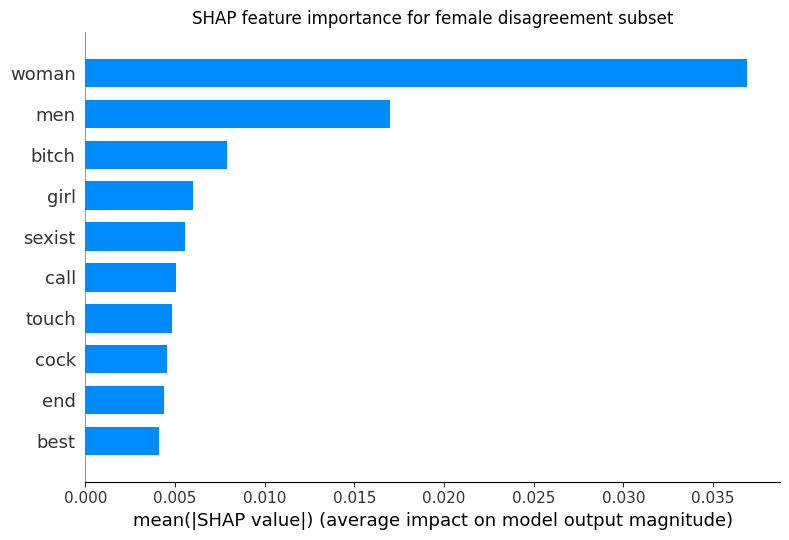

In [36]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train_f, 
                  features = X_train_f.toarray(),
                  feature_names = vec_f.get_feature_names_out(),
                  plot_type='bar',
                  max_display=10,
                  show=False)
plt.title("SHAP feature importance for female disagreement subset")
plt.tight_layout()
plt.show()

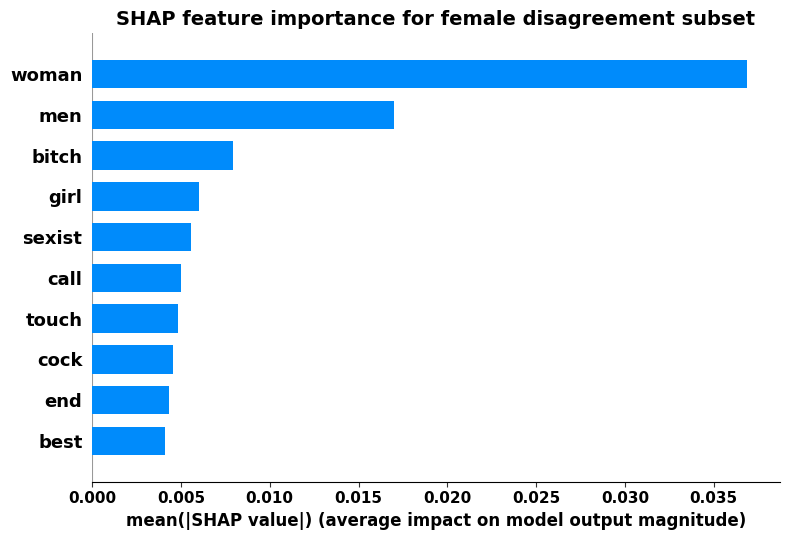

In [37]:
fig = plt.figure(figsize=(6, 6))

# Generate the SHAP summary plot
shap.summary_plot(shap_values=shapley_values_train_f, 
                  features=X_train_f.toarray(),
                  feature_names=vec_f.get_feature_names_out(),
                  plot_type='bar',
                  max_display=10,
                  show=False)

# Make the text darker by setting color and font weight
plt.title("SHAP feature importance for female disagreement subset", fontsize=14, color='black', fontweight='bold')
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=12, color='black', fontweight='bold')
plt.xticks(color='black', fontweight='bold')
plt.yticks(color='black', fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

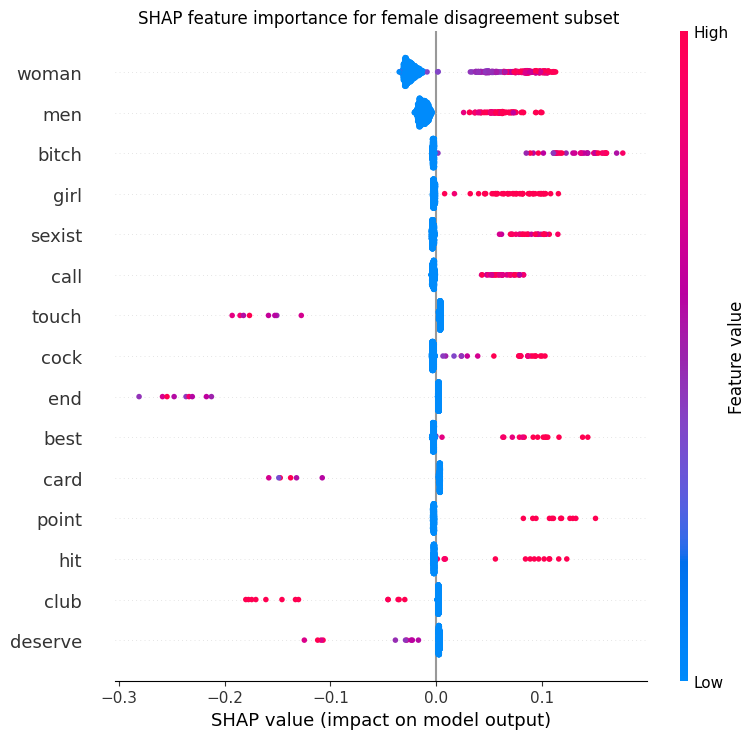

In [38]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train_f, 
                  features = X_train_f.toarray(),
                  feature_names = vec_f.get_feature_names_out(),
                  max_display=15,
                  show=False)
plt.title("SHAP feature importance for female disagreement subset ")
plt.tight_layout()
plt.show()

shap for male disagreement subset

In [39]:
features_m=vec_m.get_feature_names_out()
#feature_importances_m = rf_model_m.feature_importances_
importances_m = pd.DataFrame(index=features_m)
#importances_m['importance'] = feature_importances_m
#importances_m['rank'] = importances_m['importance'].rank(ascending=False).values
#importances_m.sort_values('rank').head(10)

In [40]:
explainer_m = shap.TreeExplainer(rf_model_m, X_train_m.toarray())

In [41]:
# Get Shap values (extended version has other data returned as well as shap values)
shapley_values_train_extended = explainer_m(X_train_m.toarray(), check_additivity=False)
shapley_values_train_m = shapley_values_train_extended.values[:,:,1]
shapley_values_test_extended = explainer_m(X_test_m.toarray(), check_additivity=False)
shapley_values_test_m = shapley_values_test_extended.values[:,:,1]

# Calculate mean Shapley value for each feature in trainign set
importances_m['mean_shapley_values'] = np.mean(shapley_values_train_m, axis=0)

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
importances_m['mean_abs_shapley_values'] = np.mean(
    np.abs(shapley_values_train_m),axis=0)

 97%|=================== | 919/944 [00:11<00:00]         

In [42]:
# Get top 10 features
#importance_top_m = importances_m.sort_values(by='importance', ascending=False).head(15).index
shapley_top_m = importances_m.sort_values(by='mean_abs_shapley_values', ascending=False).head(10).index

# Add to DataFrame
top_m_features = pd.DataFrame()
#top_m_features['importances'] = importance_top_m.values
top_m_features['Shapley'] = shapley_top_m.values

# Display
top_m_features

,Shapley
0,woman
1,men
2,cunt
3,race
4,right
5,bitch
6,sexist
7,first
8,good
9,make


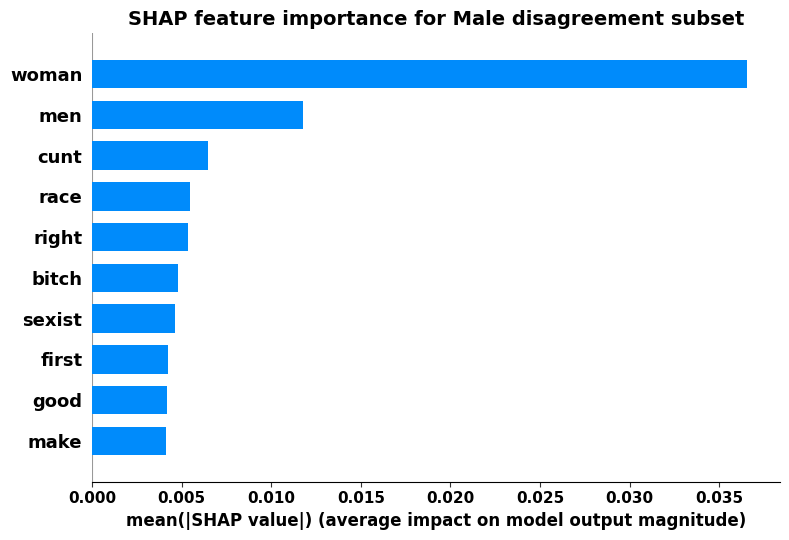

In [43]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train_m, 
                  features = X_train_m.toarray(),
                  feature_names = vec_m.get_feature_names_out(),
                  plot_type='bar',
                  max_display=10,
                  show=False)

# Make the text darker by setting color and font weight
plt.title("SHAP feature importance for Male disagreement subset", fontsize=14, color='black', fontweight='bold')
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=12, color='black', fontweight='bold')
plt.xticks(color='black', fontweight='bold')
plt.yticks(color='black', fontweight='bold')

plt.tight_layout()
plt.show()

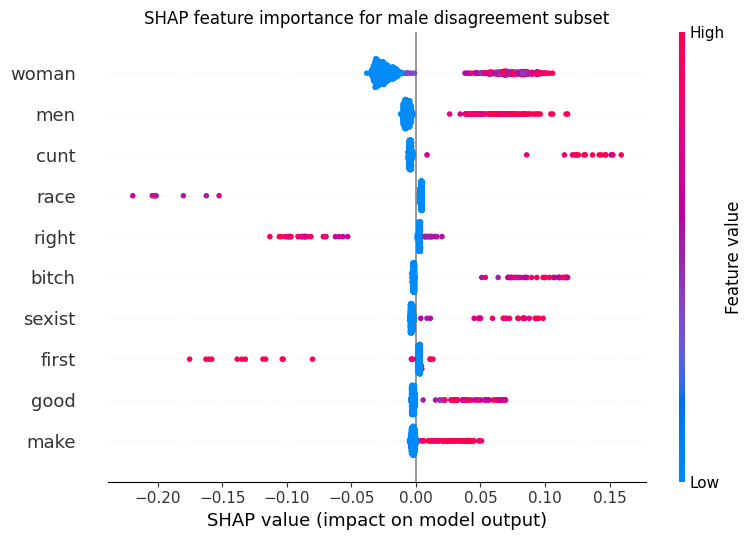

In [44]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train_m, 
                  features = X_train_m.toarray(),
                  feature_names = vec_m.get_feature_names_out(),
                  max_display=10,
                  show=False)
plt.title("SHAP feature importance for male disagreement subset")
plt.tight_layout()
plt.show()

Spearman correlation

In [45]:
from scipy.stats import spearmanr

In [46]:
shap_mean_f=top_features_f['Shapley']
shap_mean_m=top_m_features['Shapley']
correlation_fm,p_value_fm=spearmanr(shap_mean_f,shap_mean_m)
# Print results
print("Spearman Rank Correlation between male annotators and female annotators")
print(f"Spearman Rank Correlation coefficient: {correlation_fm:.4f}")
print(f"p-value: {p_value_fm:.4f}")

Spearman Rank Correlation between male annotators and female annotators
Spearman Rank Correlation coefficient: 0.8545
p-value: 0.0016
